In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [4]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB 660.6 kB/s eta 0:03:47
   ---------------------------------------- 0.1/150.0 MB 1.4 MB/s eta 0:01:44
   ---------------------------------------- 0.3/150.0 MB 2.5 MB/s eta 0:00:59
   ---------------------------------------- 0.5/150.0 MB 3.0 MB/s eta 0:00:51
   ---------------------------------------- 0.7/150.0 MB 3.4 MB/s eta 0:00:45
   ---------------------------------------- 1.0/150.0 MB 3.7 MB/s eta 0:00:41
   ---------------------------------------- 1.1/150.0 MB 3.8 MB/s eta 0:00:40
   ---------------------------------------- 1.4/150.0 MB 3.7 MB/s eta 0:00:40
   ---------------------------------------- 1.6/150.0 MB 3.7 MB/s eta 0:00:40
   ---------------------------------------- 1.8/150.0 MB 3.9 MB/s eta 0:00:3

In [5]:
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [6]:
data = pd.read_csv("data1_updated.csv")

In [7]:
if 'image_name' in data.columns:
    data.drop(columns=['image_name'], axis=1, inplace=True)

In [8]:
X = data.drop('category', axis=1)
y = data['category']

In [9]:
laben = LabelEncoder()
y = laben.fit_transform(y)


In [10]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Hyper-parameter Tuning for SVM

In [11]:
svm_params = {
    'C': [0.1, 1, 10, 100],  # Regularization strength
    'kernel': ['linear', 'rbf'],  # Linear vs. non-linear
}
svm_model = SVC(probability=True, random_state=42)
svm_grid = GridSearchCV(svm_model, svm_params, cv=cv, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X, y)
best_svm = svm_grid.best_estimator_
print(f"Best SVM Params: {svm_grid.best_params_}")

Best SVM Params: {'C': 100, 'kernel': 'rbf'}


Hyper-parameter Tuning for RF

In [12]:
rf_params = {
    'n_estimators': [100, 300, 500],  # Number of trees
    'max_depth': [10, 20, None],  # Tree depth
    'min_samples_split': [2, 5, 10]  # Minimum samples to split
}
rf_model = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf_model, rf_params, cv=cv, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X, y)
best_rf = rf_grid.best_estimator_
print(f"Best Random Forest Params: {rf_grid.best_params_}")

Best Random Forest Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}


Hyper-parameter Tuning for XGBOOST

In [13]:
xgb_params = {
    'n_estimators': [100, 300, 500],  # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage
    'max_depth': [3, 6, 10]  # Maximum tree depth
}
xgb_model = XGBClassifier(objective='multi:softprob', random_state=42)
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=cv, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X, y)
best_xgb = xgb_grid.best_estimator_
print(f"Best XGBoost Params: {xgb_grid.best_params_}")

Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}


Optimized Ensemble

In [14]:
ensemble = VotingClassifier(
    estimators=[
        ('svm', best_svm),
        ('rf', best_rf),
        ('xgb', best_xgb)
    ],
    voting='soft'
)

Cross-validation on Optimized Ensemble

In [15]:
from sklearn.model_selection import cross_validate

scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
cv_results = cross_validate(ensemble, X, y, cv=cv, scoring=scoring)

Print Final Result

In [16]:
print("\nOptimized Cross-Validation Results (5-Fold):")
print(f"  Accuracy:  {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
print(f"  Precision: {cv_results['test_precision_weighted'].mean():.4f}")
print(f"  Recall:    {cv_results['test_recall_weighted'].mean():.4f}")
print(f"  F1-score:  {cv_results['test_f1_weighted'].mean():.4f}")


Optimized Cross-Validation Results (5-Fold):
  Accuracy:  0.9582 ± 0.0046
  Precision: 0.9591
  Recall:    0.9582
  F1-score:  0.9584


Doing Feature selection

In [17]:
import matplotlib.pyplot as plt
import numpy as np

In [18]:
feature_importance = best_rf.feature_importances_

In [19]:
sorted_idx = np.argsort(feature_importance)[::-1]
sorted_features = X.columns[sorted_idx]

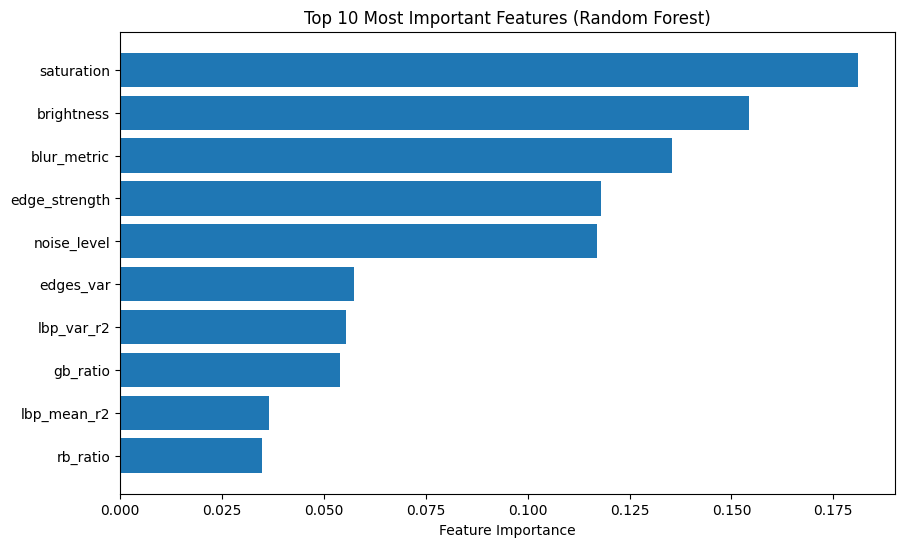

In [20]:
plt.figure(figsize=(10, 6))
plt.barh(sorted_features[:10], feature_importance[sorted_idx][:10])
plt.xlabel("Feature Importance")
plt.title("Top 10 Most Important Features (Random Forest)")
plt.gca().invert_yaxis()
plt.show()

In [21]:
from sklearn.feature_selection import SelectFromModel

In [22]:
# Select important features
selector = SelectFromModel(best_rf, threshold="median", prefit=True)
X_selected = selector.transform(X)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [23]:
# Train again with reduced features
cv_results_selected = cross_validate(ensemble, X_selected, y, cv=cv, scoring=scoring)

In [24]:
# Print results
print("\nAfter Feature Selection (5-Fold):")
print(f"  Accuracy:  {cv_results_selected['test_accuracy'].mean():.4f} ± {cv_results_selected['test_accuracy'].std():.4f}")


After Feature Selection (5-Fold):
  Accuracy:  0.9550 ± 0.0051


Using Stacking

In [25]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [26]:
# Use stacking with logistic regression as meta-classifier
stacked_ensemble = StackingClassifier(
    estimators=[
        ('svm', best_svm),
        ('rf', best_rf),
        ('xgb', best_xgb)
    ],
    final_estimator=LogisticRegression()
)

In [27]:
# Evaluate stacked ensemble
cv_results_stacked = cross_validate(stacked_ensemble, X, y, cv=cv, scoring=scoring)

print("\nStacked Ensemble Results (5-Fold):")
print(f"  Accuracy:  {cv_results_stacked['test_accuracy'].mean():.4f} ± {cv_results_stacked['test_accuracy'].std():.4f}")


Stacked Ensemble Results (5-Fold):
  Accuracy:  0.9561 ± 0.0054


## Using LightGBM

In [29]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.5 MB 667.8 kB/s eta 0:00:03
   ------ --------------------------------- 0.2/1.5 MB 2.4 MB/s eta 0:00:01
   ------------- -------------------------- 0.5/1.5 MB 3.5 MB/s eta 0:00:01
   --------------- ------------------------ 0.6/1.5 MB 3.9 MB/s eta 0:00:01
   ---------------------- ----------------- 0.8/1.5 MB 3.4 MB/s eta 0:00:01
   --------------------------- ------------ 1.0/1.5 MB 3.5 MB/s eta 0:00:01
   ---------------------------------- ----- 1.3/1.5 MB 3.8 MB/s eta 0:00:01
   ---------------------------------------  1.4/1.5 MB 4.0 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 3.7 MB/s eta 0:00:00


In [30]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

In [31]:
data = pd.read_csv("data1_updated.csv")

In [32]:
if 'image_name' in data.columns:
    data.drop(columns=['image_name'], axis=1, inplace=True)

In [33]:
X = data.drop('category', axis=1)
y = data['category']

In [34]:
le = LabelEncoder()
y_encoded = le.fit_transform(y.values.ravel())
y = np.asarray(y_encoded).ravel()

# 5. Define base models (replacing XGBoost with LightGBM)
svm_model = SVC(kernel='linear', C=1.0, probability=True, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
lgbm_model = LGBMClassifier(n_estimators=300, learning_rate=0.05, max_depth=7, random_state=42)  # LightGBM

In [35]:
ensemble = VotingClassifier(
    estimators=[
        ('svm', svm_model),
        ('rf', rf_model),
        ('lgbm', lgbm_model)  # Using LightGBM instead of XGBoost
    ],
    voting='soft'
)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_weighted',
    'recall': 'recall_weighted',
    'f1': 'f1_weighted'
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = cross_validate(
    ensemble,
    X, y,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 6614, number of used features: 14
[LightGBM] [Info] Start training from score -1.386597
[LightGBM] [Info] Start training from score -1.385992
[LightGBM] [Info] Start training from score -1.386597
[LightGBM] [Info] Start training from score -1.385992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

In [36]:
# Print average metrics
print("LightGBM-Based Ensemble Results (5-Fold):")
print(f"  Accuracy:  {results['test_accuracy'].mean():.4f} ± {results['test_accuracy'].std():.4f}")
print(f"  Precision: {results['test_precision'].mean():.4f}")
print(f"  Recall:    {results['test_recall'].mean():.4f}")
print(f"  F1-score:  {results['test_f1'].mean():.4f}")

LightGBM-Based Ensemble Results (5-Fold):
  Accuracy:  0.9588 ± 0.0034
  Precision: 0.9595
  Recall:    0.9588
  F1-score:  0.9589


Lightgbm hyper-parameter optimization

In [ ]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

# Define the parameter grid for LightGBM
param_grid = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 50],
    'max_depth': [5, 7, 10],
    'min_child_samples': [10, 20, 30]
}

# Initialize base model
lgbm = LGBMClassifier(random_state=42)

# Grid search
grid_search = GridSearchCV(lgbm, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X, y)

# Get the best model
best_lgbm = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


Using best lightgbm model

In [40]:
ensemble = VotingClassifier(
    estimators=[
        ('svm', svm_model),
        ('rf', rf_model),
        ('lgbm', best_lgbm)  # Best LightGBM model
    ],
    voting='soft'
)

# Perform cross-validation again
results = cross_validate(ensemble, X, y, cv=cv, scoring=scoring)

# Print updated results
print("Optimized LightGBM Ensemble (5-Fold):")
print(f"  Accuracy:  {results['test_accuracy'].mean():.4f} ± {results['test_accuracy'].std():.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 6614, number of used features: 14
[LightGBM] [Info] Start training from score -1.386597
[LightGBM] [Info] Start training from score -1.385992
[LightGBM] [Info] Start training from score -1.386597
[LightGBM] [Info] Start training from score -1.385992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

final accuracy is 95.73%

## without optimization accuracy is 95.88%

## using lightgbm instead of xgboost